In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns
import pymc3.sampling as sampling
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class Multivariate_T(object):
    def __init__(self,mu,sigma,N):
        '''
        Output:
        Produce M samples of d-dimensional multivariate t distribution
        Input:
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        N = degrees of freedom
        '''
        self.mu = mu
        self.sigma = sigma
        self.N = N
    
    def rvs(self,M):
        '''
           M = # of samples to produce
        '''
        d = len(self.sigma)
        g = np.tile(np.random.gamma(self.N/2.,2./self.N,M),(d,1)).T
        Z = np.random.multivariate_normal(np.zeros(d),self.sigma,M)
        return self.mu + Z/np.sqrt(g)

## Portfolio optimisation


Demiguel Nogalwes 2009 ran a model as follows:

they assume the true asset-return distribution is given as $$\mathbf{X} = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$


In our scenario, we assume the stocks are generated from a multivariate T distribution
$$ \mathbf{X} \sim \mathcal{t}_{\nu}(\mathbf{\mu},\mathbf{\Sigma})$$
</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [3]:
# this is the mean and covariance of the multivariate distribution
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])
#model = st.multivariate_normal(mean=mu,cov=covar)
model = Multivariate_T(mu,covar,3.5)

In [4]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [5]:
def sum_weights(weights):
    return np.sum(weights)-1

In [6]:
def mle_mv_gaussian(mean_est,cov_est,gamma,average=False):
    res = minimize(mean_variance,init_weights,args=(mean_est,cov_est,gamma,
                                                    average),
                  constraints=constraints,
                  bounds=[(0,None)]*5)
    return res.x

In [7]:
class SAA(object):
    def __init__(self,
                 objective_function,
                 initial_conditions,
                 constraints,
                 bounds):
        self.objective_function = objective_function
        self.initial_conditions = initial_conditions
        self.constraints = constraints
        self.bounds = bounds
    def solve(self,samples,use_average=False,*args,**kwargs):
        if 'cov_est' not in kwargs:
            cov_est = np.cov(samples.T)
        else:
            cov_est = kwargs['cov_est']
        if 'mean_est' not in kwargs:
            mean_est = np.mean(samples,axis=0)
        else:
            mean_est = kwargs['mean_est']  
        res = minimize(self.objective_function,
                       self.initial_conditions,
                       args=(mean_est,
                            cov_est,
                            kwargs['gamma'],
                            use_average),
                      constraints=self.constraints,
                      bounds=self.bounds)
        return res.x

In [8]:
class BaggingSolver(SAA):
    def __init__(self,iterations=500,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.iterations=iterations
    
    def solve(self,samples,*args,**kwargs):
        result_array = []
        sample_size = samples.shape[0]
        for i in range(self.iterations):
            indexs = np.random.choice(range(sample_size),
                                      size=sample_size,
                                      replace=True)
            bootstrapped_samples = samples[indexs]
            result_array.append(super().solve(bootstrapped_samples,*args,**kwargs))
        return np.mean(result_array,axis=0)

In [9]:
class BayesianSolver(SAA):
    def __init__(self,mu0,m,Psi,nu0,iterations=5000,*args,**kwargs):
        super().__init__(*args,**kwargs)
        # define priors
        self.mu0 = mu0
        self.m = m
        self.Psi = Psi
        self.nu0 = nu0
        self.iterations = iterations
    
    def solve(self,samples,*args,**kwargs):
            n = samples.shape[0]
            sample_mean = np.mean(samples,axis=0)
            sample_cov = np.cov(samples.T)
            posterior_sigma_scale = (self.Psi+n*sample_cov+self.m*n/(n+self.m)*np.dot(
                                                                            sample_mean-self.mu0,
                                                                            (sample_mean-self.mu0).T))
            posterior_sigma_nu = n+self.nu0
            post_invwish = st.invwishart(scale=posterior_sigma_scale,
                                        df=posterior_sigma_nu)
            cov_array = []
            mean_array = []
            for k in range(self.iterations):
                cov_array.append(post_invwish.rvs())
                posterior_mean_mu = (n*sample_mean+self.m*self.mu0)/(self.m+n)
                #mean_wishart = posterior_sigma_scale/(posterior_sigma_nu-sample_mean.shape[0]-1)
                posterior_mean_sigma = 1/(self.m+n)*cov_array[k]
                mean_array.append(st.multivariate_normal.rvs(posterior_mean_mu,
                                                            posterior_mean_sigma))
            result = super().solve(samples,
                                  mean_est=np.array(mean_array),
                                 cov_est=np.array(cov_array),
                                 gamma=kwargs['gamma'],
                                 use_average=True)    
            return result

In [67]:
def fix_string(x):
    return np.array([float(z) for z in x[1:-1].split(' ') if z is not ""])

In [11]:
init_weights = np.ones((5))/5
gamma = [10,20,50]
N = [50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [12]:
n_iter = 500

In [13]:
saa = SAA(mean_variance,init_weights,constraints,[(0,None)]*5)
bagger = BaggingSolver(mean_variance,init_weights,constraints,[(0,None)]*5)

TypeError: __init__() missing 1 required positional argument: 'bounds'

In [25]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            w_star = saa.solve(samples,gamma=gamma[j])   
            results = {'w_star': w_star,'method':'SAA','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)
            w_star = bagger.solve(samples,
                                  gamma=gamma[j])   
            results = {'w_star': w_star,'method':'bagging','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)
            
    w_star = saa.solve(samples,mu_est=mu,cov_est=covar,gamma=gamma[j])         
    results = {'w_star': w_star,'method':'True','gamma':gamma[j],'N':N[i]}
    df = df.append(results,ignore_index=True)

In [34]:
df.to_csv("t_dist_portfolio_opt.csv")

In [22]:
df = pd.read_csv("t_dist_portfolio_opt.csv",index_col=0)

In [26]:
#df['w_star'] = df['w_star'].apply(lambda x:fix_string(x))
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))
df['mean_variance'] = df.apply(lambda x:mean_variance(x['w_star'],
                                                      mu,
                                                      covar,
                                                      x['gamma']),
                                axis=1)

In [27]:
df[df['method']=='True']

,w_star,method,gamma,N,mean_variance,expected_return
60,"[0.4632165043904952, 0.0, 0.0, 0.5367834956095...",True,10,200,0.973791,27.489534
121,"[0.6016405147037771, 3.144186300207963e-18, 0....",True,20,200,2.340181,27.133784
182,"[0.6878936208293842, 0.0, 2.3418766925686896e-...",True,50,200,3.150897,26.912113
3183,"[0.4387649370111663, 9.020562075079397e-17, 1....",True,10,200,0.973802,27.552374
6184,"[0.5977111191820492, 0.0, 7.39425881635114e-17...",True,20,200,2.340182,27.143882
9185,"[0.6881734344931303, 6.071532165918825e-17, 0....",True,50,200,3.150897,26.911394


In [32]:
gamma_df = df[df['gamma']==50.0]

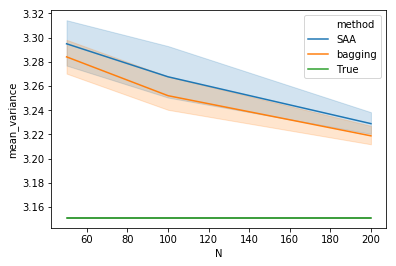

In [33]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,color='g')

## Using Bayesian inference

We use a normal-inversewishart prior on the mean and covariance of the multivariate gaussian.
$$p(\Sigma)\sim \mathcal{W}^{-1}(\mathbf{5I},5)$$
$$p(\mu|\Sigma)\sim \mathcal{N}([27,27,27,27,27],\Sigma)$$

In [72]:
mu0 = np.array([27]*5)
m = 1
Psi = 5*np.eye(5)
nu0 = 5
bayes = BayesianSolver(mu0,m,Psi,nu0,5000,
    mean_variance,init_weights,constraints,[(0,None)]*5)

In [14]:
def bayesian_portfolio(samples,n_samples=2000):
    # known scaling
    with pm.Model() as model:
        #sd_dist = pm.HalfCauchy.dist(beta=2.5)
        sd_dist = pm.Gamma.dist(alpha=7.5,beta=1.0)
        chol_dist = pm.LKJCholeskyCov('chol',n=5,eta=2,
                                      sd_dist=sd_dist)
        chol = pm.expand_packed_triangular(5, chol_dist, lower=True)
        mu_dist = pm.MvNormal('mu',chol=chol, mu=mu0,shape=5)
        observed = pm.MvNormal('obs',mu=mu_dist,chol=chol,observed=samples)
        Sigma = pm.Deterministic('cov', chol.dot(chol.T))
        # Using Metropolis Hastings Sampling
        #step = pm.HamiltonianMC()
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        trace = pm.sample(n_samples,step=step,njobs=4,progressbar=False,cores=4)
        
        #new_samples = np.reshape(sampling.sample_ppc(trace,samples=n_samples,
        #            model=model,
        #            progressbar=False)['obs'],(-1,5))    
    return trace

In [93]:
n_iter = 200

In [94]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            w_star = bayes.solve(samples,
                                  gamma=gamma[j])   
            results = {'w_star': w_star,'method':'Bayesian','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)

In [98]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(
                                            mu,x))
df['mean_variance'] = df.apply(lambda x:mean_variance(x['w_star'],
                                                      mu,
                                                      covar,
                                                      x['gamma']),
                                axis=1)

In [105]:
df.to_csv("t_dist_portfolio_opt.csv")

The plots below show the results of three methods. SAA, bayesian and another called bagging. Its an approached used in small data machine learning problems to reduce variance and bias. From wikipedia:
> Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. 

The algorithm is as follows: <br/>
for $i$ in $N$:<br/>
1. sample from the dataset uniformly,$D$, with replacement creating a new dataset (with possible duplicate points from the original) called $d_i$. 
2. A result, $x^*_i$ is computed using SAA using $d_i$.
<br/>
end for
<br/>
A final result is obtained by averaging, $\bar{x}^*$



Text(0.5, 1.0, 'Gamma = 10.0')

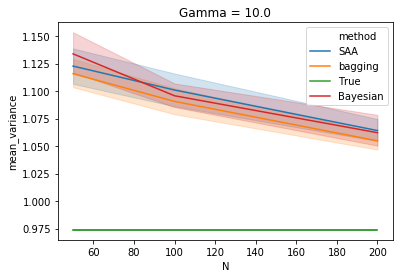

In [128]:
gamma_df = df[df['gamma']==10.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,
             color='green')
#ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
#                  hue=gamma_df['method'],ax=axes[1])
#axes[1].plot(N,
#             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
#             color='green')
plt.title('Gamma = 10.0')

Text(0.5, 1.0, 'Gamma = 10.0')

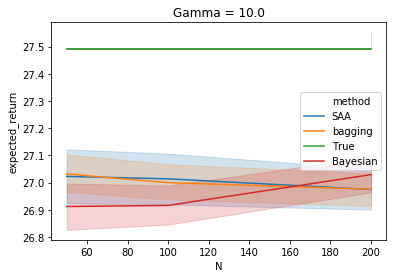

In [131]:
gamma_df = df[df['gamma']==10.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
             color='green')
#ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
#                  hue=gamma_df['method'],ax=axes[1])
#axes[1].plot(N,
#             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
#             color='green')
plt.title('Gamma = 10.0')

Text(0.5, 1.0, 'Gamma = 20.0')

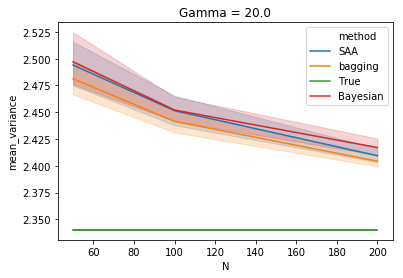

In [130]:
gamma_df = df[df['gamma']==20.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,
             color='green')
plt.title('Gamma = 20.0')

Text(0.5, 1.0, 'Gamma = 10.0')

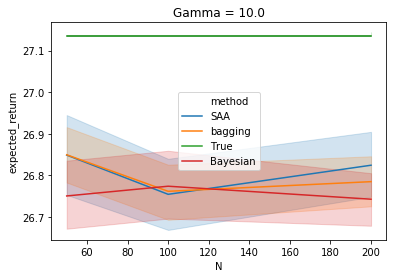

In [132]:
gamma_df = df[df['gamma']==20.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
             color='green')
#ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
#                  hue=gamma_df['method'],ax=axes[1])
#axes[1].plot(N,
#             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
#             color='green')
plt.title('Gamma = 10.0')

Text(0.5, 1.0, 'Gamma = 50.0')

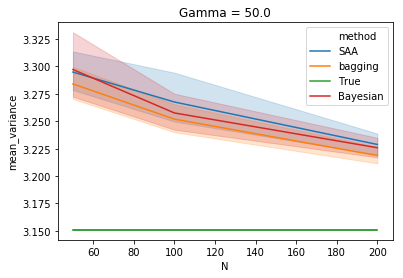

In [129]:
gamma_df = df[df['gamma']==50.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,
             color='green')
plt.title('Gamma = 50.0')

Text(0.5, 1.0, 'Gamma = 50.0')

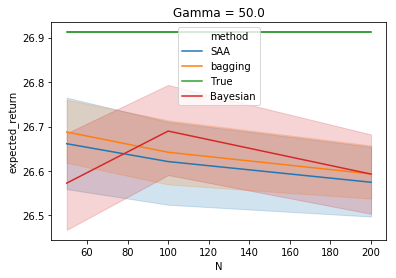

In [133]:
gamma_df = df[df['gamma']==50.0]
#f, axes = plt.subplots(1, 2,figsize=(8,6))
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,
             [gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,
             color='green')
plt.title('Gamma = 50.0')